In [1]:
import logging
import os
import sys
import shutil
import tempfile
import pandas as pd

import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np

import monai
from monai.networks.nets import resnet18
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import DataLoader, ImageDataset
from monai.transforms import (
    EnsureChannelFirst,
    Compose,
    RandRotate90,
    Resize,
    ScaleIntensity,
)
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
print_config()

MONAI version: 1.2.0
Numpy version: 1.26.0
Pytorch version: 2.1.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: /root/miniconda3/envs/cmri/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.3.0
Nibabel version: 5.1.0
scikit-image version: 0.19.3
Pillow version: 10.0.1
Tensorboard version: 2.12.1
gdown version: 4.7.1
TorchVision version: 0.16.0
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.1.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-rec

,0,1
0,P1_T1.nii.gz,0
1,P2_T1.nii.gz,0
2,P3_T1.nii.gz,0
3,P4_T1.nii.gz,0
4,P5_T1.nii.gz,0
...,...,...
149,P150_T1.nii.gz,1
150,P151_T1.nii.gz,1
151,P153_T1.nii.gz,1
152,P154_T1.nii.gz,1


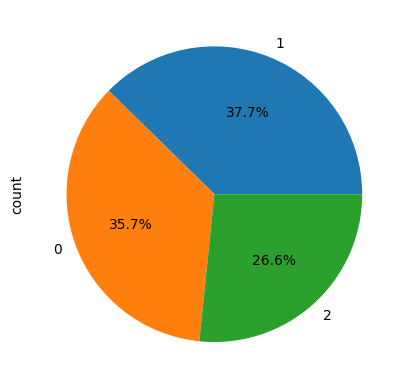

In [2]:
df = pd.read_csv("GEMS_T1_labels.csv", header=None)
group_counts = df[1].value_counts()
group_counts.plot(kind='pie',autopct='%1.1f%%')
df

In [3]:
data_path = "~/GEMS_T1_DeepLearning"
labels = df[1].tolist()
converted_labels = [1 if x != 0 else 0 for x in labels]
#labels = converted_labels
images = []
for i in df[0].tolist():
    images = images+ [os.path.join(data_path, i)]
    
images

['~/GEMS_T1_DeepLearning/P1_T1.nii.gz',
 '~/GEMS_T1_DeepLearning/P2_T1.nii.gz',
 '~/GEMS_T1_DeepLearning/P3_T1.nii.gz',
 '~/GEMS_T1_DeepLearning/P4_T1.nii.gz',
 '~/GEMS_T1_DeepLearning/P5_T1.nii.gz',
 '~/GEMS_T1_DeepLearning/P6_T1.nii.gz',
 '~/GEMS_T1_DeepLearning/P7_T1.nii.gz',
 '~/GEMS_T1_DeepLearning/P8_T1.nii.gz',
 '~/GEMS_T1_DeepLearning/P9_T1.nii.gz',
 '~/GEMS_T1_DeepLearning/P10_T1.nii.gz',
 '~/GEMS_T1_DeepLearning/P11_T1.nii.gz',
 '~/GEMS_T1_DeepLearning/P12_T1.nii.gz',
 '~/GEMS_T1_DeepLearning/P13_T1.nii.gz',
 '~/GEMS_T1_DeepLearning/P14_T1.nii.gz',
 '~/GEMS_T1_DeepLearning/P15_T1.nii.gz',
 '~/GEMS_T1_DeepLearning/P16_T1.nii.gz',
 '~/GEMS_T1_DeepLearning/P17_T1.nii.gz',
 '~/GEMS_T1_DeepLearning/P18_T1.nii.gz',
 '~/GEMS_T1_DeepLearning/P19_T1.nii.gz',
 '~/GEMS_T1_DeepLearning/P20_T1.nii.gz',
 '~/GEMS_T1_DeepLearning/P21_T1.nii.gz',
 '~/GEMS_T1_DeepLearning/P22_T1.nii.gz',
 '~/GEMS_T1_DeepLearning/P23_T1.nii.gz',
 '~/GEMS_T1_DeepLearning/P24_T1.nii.gz',
 '~/GEMS_T1_DeepLearning/

In [4]:
labels = torch.nn.functional.one_hot(torch.as_tensor(labels)).float()

In [5]:
train_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(),Resize((128, 128, 128)), RandRotate90()])

val_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(), Resize((128, 128, 128))])

check_ds = ImageDataset(image_files=images, labels=labels, transform=train_transforms)

check_loader = DataLoader(check_ds, batch_size=2, num_workers = 4, pin_memory=pin_memory)
im, label = monai.utils.misc.first(check_loader)
print(type(im), im.shape, label, label.shape)

<class 'monai.data.meta_tensor.MetaTensor'> torch.Size([2, 1, 128, 128, 128]) tensor([[1., 0., 0.],
        [1., 0., 0.]]) torch.Size([2, 3])


In [6]:
train_ds = ImageDataset(image_files=images[:108], labels=labels[:108] , transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=2, num_workers =0,  shuffle=True, pin_memory=pin_memory)

# create a validation data loader
val_ds = ImageDataset(image_files=images[-46:], labels=labels[-46:] , transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=2, pin_memory=pin_memory)


<class 'monai.data.meta_tensor.MetaTensor'> torch.Size([2, 1, 128, 128, 128]) tensor([[0., 0., 1.],
        [1., 0., 0.]]) torch.Size([2, 3])


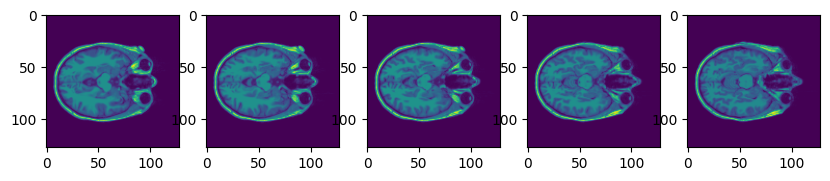

In [7]:
im, label = monai.utils.misc.first(train_loader)
print(type(im), im.shape, label, label.shape)
for i in range(5):
    plt.subplot(5, 5,i + 1)
    plt.imshow(im[0,0,:,59 + i])
    plt.gcf().set_size_inches(10, 10)
plt.show()

In [8]:
#from monai import model_constructor
net = resnet18(
        pretrained=False,
        spatial_dims=3,
        n_input_channels=1,
        num_classes=3
    )
net_dict = net.state_dict()
pretrain = torch.load("resnet_18_23dataset.pth")
pretrain['state_dict'] = {k.replace('module.', ''): v for k, v in pretrain['state_dict'].items()}
# #missing = tuple({k for k in net_dict.keys() if k not in pretrain['state_dict']})
# #logging.debug(f"missing in pretrained: {len(missing)}")
# #inside = tuple({k for k in pretrain['state_dict'] if k in net_dict.keys()})
# #logging.debug(f"inside pretrained: {len(inside)}")
# #unused = tuple({k for k in pretrain['state_dict'] if k not in net_dict.keys()})
# #logging.debug(f"unused pretrained: {len(unused)}")
# assert len(inside) > len(missing)
# assert len(inside) > len(unused)

pretrain['state_dict'] = {k: v for k, v in pretrain['state_dict'].items() if k in net_dict.keys()}
net.load_state_dict(pretrain['state_dict'], strict=False)



_IncompatibleKeys(missing_keys=['layer2.0.downsample.0.weight', 'layer2.0.downsample.0.bias', 'layer2.0.downsample.1.weight', 'layer2.0.downsample.1.bias', 'layer2.0.downsample.1.running_mean', 'layer2.0.downsample.1.running_var', 'layer3.0.downsample.0.weight', 'layer3.0.downsample.0.bias', 'layer3.0.downsample.1.weight', 'layer3.0.downsample.1.bias', 'layer3.0.downsample.1.running_mean', 'layer3.0.downsample.1.running_var', 'layer4.0.downsample.0.weight', 'layer4.0.downsample.0.bias', 'layer4.0.downsample.1.weight', 'layer4.0.downsample.1.bias', 'layer4.0.downsample.1.running_mean', 'layer4.0.downsample.1.running_var', 'fc.weight', 'fc.bias'], unexpected_keys=[])

In [9]:
model = net.to(device)
#model = monai.networks.nets.DenseNet121(spatial_dims=3, in_channels=1, out_channels=2).to(device)

#loss_function = torch.nn.CrossEntropyLoss()
loss_function = torch.nn.BCEWithLogitsLoss()  # also works with this data

optimizer = torch.optim.Adam(model.parameters(), 1e-4)

# start a typical PyTorch training
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()
max_epochs = 5

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()

        num_correct = 0.0
        metric_count = 0
        for val_data in val_loader:
            val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
            with torch.no_grad():
                val_outputs = model(val_images)
                value = torch.eq(val_outputs.argmax(dim=1), val_labels.argmax(dim=1))
                metric_count += len(value)
                num_correct += value.sum().item()

        metric = num_correct / metric_count
        metric_values.append(metric)

        if metric > best_metric:
            best_metric = metric
            best_metric_epoch = epoch + 1
            torch.save(model.state_dict(), "best_metric_model_classification3d_array.pth")
            print("saved new best metric model")

        print(f"Current epoch: {epoch+1} current accuracy: {metric:.4f} ")
        print(f"Best accuracy: {best_metric:.4f} at epoch {best_metric_epoch}")
        writer.add_scalar("val_accuracy", metric, epoch + 1)

print(f"Training completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/5


1/54, train_loss: 0.6368
2/54, train_loss: 0.5841
3/54, train_loss: 0.6823
4/54, train_loss: 0.6191
5/54, train_loss: 0.6183
6/54, train_loss: 0.8895
7/54, train_loss: 0.7211
8/54, train_loss: 0.6668
9/54, train_loss: 0.4904
10/54, train_loss: 0.6652
11/54, train_loss: 0.6398
12/54, train_loss: 0.6061
13/54, train_loss: 0.7551
14/54, train_loss: 0.7081
15/54, train_loss: 0.6865
16/54, train_loss: 0.6493
17/54, train_loss: 0.5581
18/54, train_loss: 0.6775
19/54, train_loss: 0.6693
20/54, train_loss: 0.5553
21/54, train_loss: 0.7451
22/54, train_loss: 0.6986
23/54, train_loss: 0.5004
24/54, train_loss: 0.4890
25/54, train_loss: 0.4699
26/54, train_loss: 0.4370
27/54, train_loss: 0.7234
28/54, train_loss: 0.8347
29/54, train_loss: 0.9251
30/54, train_loss: 0.5826
31/54, train_loss: 0.3933
32/54, train_loss: 0.3902
33/54, train_loss: 0.5796
34/54, train_loss: 0.5774
35/54, train_loss: 0.6178
36/54, train_loss: 0.3775
37/54, train_loss: 0.8133
38/54, train_loss: 0.5898
39/54, train_loss: 0.